In [0]:
!unzip DATA-2.zip


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        #print(image_ids[0])
        #print(label_ids[0])
        #print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('DATA', 'trainSet-2.csv')
valset = UVaBuildinglabel('DATA', 'valSet-2.csv')

print("total training data",trainset.__len__())
print("total validation data",valset.__len__())

Loading data...
Loading data...
total training data 616
total validation data 153


In [0]:
def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,shuffle=False, num_workers=2)

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net=net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        #print(epoch)
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data

            #print(inputs.shape)
            #print(labels.shape)
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print(outputs.shape)
            #print(labels)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)

            #print(max_scores)
            #print(max_labels)

            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            
    print('Finished Training')


    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses, 'bo-', label = 'val-loss')
    plt.plot(train_losses, 'ro-', label = 'train-loss')
    plt.grid('on')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'bo-', label = 'val-acc')
    plt.plot(train_accuracies, 'ro-', label = 'train-acc')
    plt.ylabel('accuracy')
    plt.grid('on')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='lower right')
    plt.show()

In [43]:
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True)
no_images_per_class = torch.zeros(20)
for (i, (my_image, my_label,_,class_name)) in enumerate(trainloader):    
  no_images_per_class[my_label.item()]+=1  

print(no_images_per_class)
#weight for loss 
class_weights = 64/no_images_per_class   #as 64 is the miximum no of immage in a category
class_weights=torch.FloatTensor(class_weights)

print(class_weights)

tensor([19., 13., 55., 27., 64., 47., 47., 16., 20., 20., 20., 23., 39., 49.,
        28., 24., 17., 20., 24., 44.])
tensor([3.3684, 4.9231, 1.1636, 2.3704, 1.0000, 1.3617, 1.3617, 4.0000, 3.2000,
        3.2000, 3.2000, 2.7826, 1.6410, 1.3061, 2.2857, 2.6667, 3.7647, 3.2000,
        2.6667, 1.4545])


Train: [28,    60] loss: 1.332 Accuracy: 0.6979
Validation: [28,    20] loss: 2.111 Accuracy: 0.6937
Train: [29,    20] loss: 2.107 Accuracy: 0.6562
Train: [29,    40] loss: 1.396 Accuracy: 0.7031
Train: [29,    60] loss: 1.281 Accuracy: 0.7125
Validation: [29,    20] loss: 1.934 Accuracy: 0.7000
Train: [30,    20] loss: 1.855 Accuracy: 0.7250
Train: [30,    40] loss: 1.499 Accuracy: 0.7375
Train: [30,    60] loss: 1.353 Accuracy: 0.7083
Validation: [30,    20] loss: 2.210 Accuracy: 0.6813
Finished Training


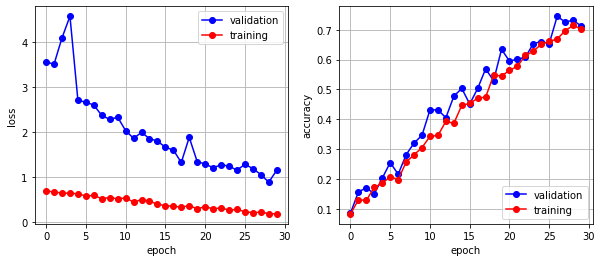

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#weight=class_weights
loss_fn = nn.CrossEntropyLoss()
resnet = models.resnet50(pretrained = False)

#print(len(trainset.image_classes))
resnet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnet, loss_fn, 8, trainset, valset, optimizer, 30)  

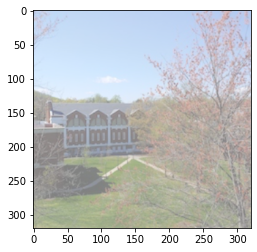

GroundTruth:  ('Memorial Gym',)
Predicted:  Memorial Gym


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])


Validation: [20,    20] loss: 2.810 Accuracy: 0.4875
Train: [21,    20] loss: 2.582 Accuracy: 0.4875
Train: [21,    40] loss: 1.848 Accuracy: 0.4688
Train: [21,    60] loss: 1.539 Accuracy: 0.4917
Validation: [21,    20] loss: 3.177 Accuracy: 0.3750
Train: [22,    20] loss: 2.283 Accuracy: 0.6500
Train: [22,    40] loss: 1.828 Accuracy: 0.5875
Train: [22,    60] loss: 1.492 Accuracy: 0.5729
Validation: [22,    20] loss: 2.481 Accuracy: 0.5563
Train: [23,    20] loss: 2.484 Accuracy: 0.5750
Train: [23,    40] loss: 1.739 Accuracy: 0.5344
Train: [23,    60] loss: 1.487 Accuracy: 0.5417
Validation: [23,    20] loss: 2.317 Accuracy: 0.5687
Train: [24,    20] loss: 2.331 Accuracy: 0.5813
Train: [24,    40] loss: 1.584 Accuracy: 0.6156
Train: [24,    60] loss: 1.473 Accuracy: 0.6042
Validation: [24,    20] loss: 2.516 Accuracy: 0.5188
Train: [25,    20] loss: 2.514 Accuracy: 0.5563
Train: [25,    40] loss: 1.671 Accuracy: 0.5719
Train: [25,    60] loss: 1.438 Accuracy: 0.5833
Validation: [25

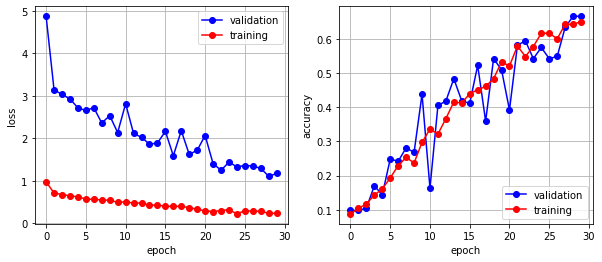

In [45]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 8, trainset, valset, optimizer, 30)   #epoch 6 can give better results

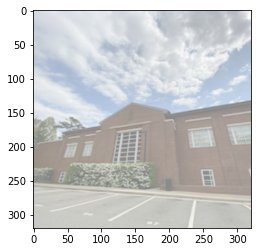

GroundTruth:  ('Aquatic & Fitness Center',)
Predicted:  Aquatic & Fitness Center


In [0]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

Train: [1,    20] loss: 4.151 Accuracy: 0.0625
Train: [1,    40] loss: 2.529 Accuracy: 0.0813
Train: [1,    60] loss: 2.005 Accuracy: 0.0854
Validation: [1,    20] loss: 4.088 Accuracy: 0.0938
Train: [2,    20] loss: 4.055 Accuracy: 0.1750
Train: [2,    40] loss: 2.511 Accuracy: 0.1250
Train: [2,    60] loss: 1.992 Accuracy: 0.1104
Validation: [2,    20] loss: 4.004 Accuracy: 0.0938
Train: [3,    20] loss: 4.070 Accuracy: 0.0813
Train: [3,    40] loss: 2.489 Accuracy: 0.0625
Train: [3,    60] loss: 1.981 Accuracy: 0.0667
Validation: [3,    20] loss: 3.971 Accuracy: 0.0938
Train: [4,    20] loss: 3.975 Accuracy: 0.1313
Train: [4,    40] loss: 2.494 Accuracy: 0.1313
Train: [4,    60] loss: 1.994 Accuracy: 0.1104
Validation: [4,    20] loss: 3.999 Accuracy: 0.0938
Train: [5,    20] loss: 4.046 Accuracy: 0.1187
Train: [5,    40] loss: 2.464 Accuracy: 0.1125
Train: [5,    60] loss: 1.992 Accuracy: 0.1104
Validation: [5,    20] loss: 4.015 Accuracy: 0.0938
Train: [6,    20] loss: 4.051 Accur

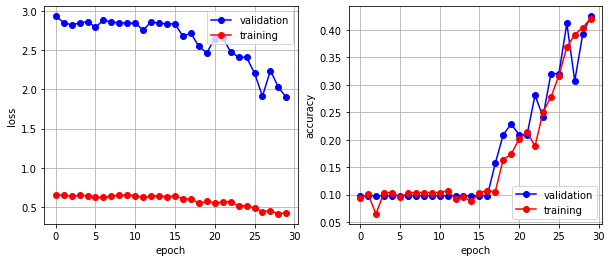

In [44]:
loss_fn = nn.CrossEntropyLoss()
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(4096, 20)
optimizer = optim.SGD(alexnet.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnet, loss_fn, 8, trainset, valset, optimizer, 30)  #epoch 6 worked better

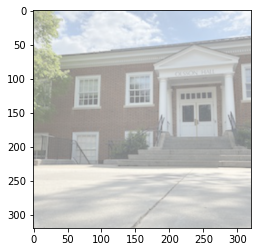

GroundTruth:  ('Olsson Hall',)
Predicted:  Olsson Hall


In [0]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])